# Homework 4: Analyzing Rates of Sea Level Rise
In this homework, you'll investigate sea level change using data from the ECCO state estimate. You'll look at spatial differences over the past few decades and then compare how sea level on the California coast compares to the global mean.

Begin by importing the modules you'll need for this notebook:

In [14]:
# import packages here
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import os
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cm
import matplotlib.ticker as mticker
import numpy as np
import statistics
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)




## Part 1: Download Sea Surface Height Data
To begin this exercise, download all of the available sea surface height data (1992-2017) from the ECCO Version 4 Release 4 output. There are several different variables for sea surface height pertaining to different components and corrections. In this homework, we'll use the `SSHDYN` variable which is equivalent to what satellites would measure from space.

To obtain the data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes.

In [2]:
# define the path to the folder where the SSH data has been download on your machine
ssh_folder = 'C:\\Users\\andre\\Desktop\\Classwork\\cs185c\\data\\ECCO\\Version4\\Release4\\interp_monthly\\SSHDYN'


## Part 2: Plot Total Sea Level Rise 1992-2017
As a first look into how sea level has changed in the past several decades, we'll look at the differences between two time periods at the beginning and end of the available model output: January 1992 and January 2017. It is important to use the same month because variations in sea level also have a seasonal cycle (as we'll see below). Begin by reading in the data:

In [3]:
# read in the longitude, latitude, and model ssh grid in January 1992 (SSHDYN_1992_01.nc)
ssh_data_1992 = os.path.join(ssh_folder, 'SSHDYN_1992_01.nc')
ds_1992 = xr.open_dataset(ssh_data_1992, decode_times=False)
longitude = np.array(ds_1992['longitude'][:])
latitude = np.array(ds_1992['latitude'][:])
ssh_1992 = np.array(ds_1992['SSHDYN'][:])

# read in the model ssh grid in January 2017 (SSHDYN_2017_01.nc)
ssh_data_2017 = os.path.join(ssh_folder, 'SSHDYN_2017_01.nc')
ds_2017 = xr.open_dataset(ssh_data_2017, decode_times=False)
ssh_2017 = np.array(ds_2017['SSHDYN'][:])


Now, make a plot of the difference between January 2017 and January 1992. Be sure to add a colorbar with a divergent colormaps and set the color bounds to be equal in the positive and negative directions.

Text(0.5, 1.0, 'Difference in Sea Surface Height (1992-2017)')

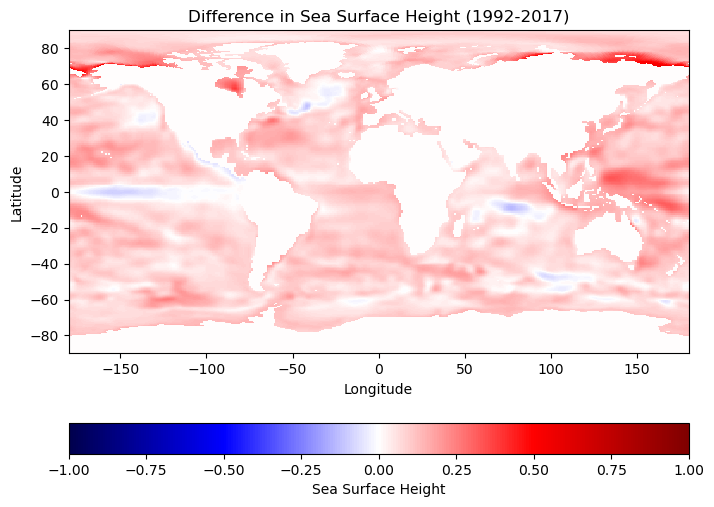

In [4]:
ssh_difference = ssh_2017 - ssh_1992

# make a plot of the differences between 2017 and 1992
fig = plt.figure(figsize=(8, 6))

plt.pcolormesh(longitude, latitude, ssh_difference[0,:,:], vmin=-1, vmax=1, cmap='seismic')
plt.colorbar(orientation='horizontal',
             label='Sea Surface Height' )

# format the axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Difference in Sea Surface Height (1992-2017)')



### Questions:
Where are the largest increases in sea level observed between these two time periods? Are there any locations on the globe where sea level has fallen? If so, where?

Answer: 

The largest increases in sea level are observed in the northern hemisphere around the 70N - 80N latitude ranges above Alaska and Russia. The largest decreases in sea level are observed around the equator and the southern hemispheres (0S-20S) in the Pacific and Indian oceans. Additionally, there are a few smaller drops in the Northern Atlantic.


## Part 3: Create a Timeseries of Sea Surface Height in California
Next, we'll make a timeseries of sea surface height at a point off the California coast near San José. A close location in the model is at 37$^{\circ}$N, 122$^{\circ}$W. Begin by finding the closest row and column in the model grid to this longitude and latitude.

In [5]:
# define the latitude and longitude
lon = -122
lat = 37

# find the row and column closest to the location of the point off the CA coast
# note that you have already read in the longitude and latitude if the grid to make the plot above
lon_row = np.argmin(np.abs(longitude - (lon)))
lat_col = np.argmin(np.abs(latitude - (lat)))


Now, armed with your sample location, loop through each sea surface height file to make a timeseries of sea level rise between 1992 and 2017. Every time you access a file, sample the model grid at the row and column you identified above.

In [6]:
ds_1992

<xarray.Dataset> Size: 2MB
Dimensions:    (i: 720, j: 360, time: 1, nv: 2)
Coordinates:
  * i          (i) int64 6kB 0 1 2 3 4 5 6 7 ... 712 713 714 715 716 717 718 719
  * j          (j) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * time       (time) int64 8B 0
    latitude   (j) float64 3kB ...
    longitude  (i) float64 6kB ...
    timestep   (time) int64 8B ...
    time_bnds  (time, nv) int64 16B ...
Dimensions without coordinates: nv
Data variables:
    SSHDYN     (time, j, i) float64 2MB ...
Attributes: (12/20)
    product_time_coverage_start:  1992-01-01T12:00:00
    author:                       Ou Wang and Ian Fenty
    Insitution:                   JPL
    product_version:              ECCO Version 4 Release 4
    time_units:                   days since 1992-01-01 00:00:00
    Conventions:                  CF-1.6
    ...                           ...
    nz:                           1
    geospatial_vertical_units:    meter
    geospatial_vertical_max:      0
    date_created:                 Wed Oct 23 23:06:44 2019
    time_coverage_start:          1992-01-01T00:00:00
    time_coverage_end:            1992-02-01T00:00:00

In [7]:
# create a timeseries of ssh at the point above by looping through all of the ssh files
# each time through the loop, sample the ssh grid at the row and column identified above
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second
ts_ca = []

for year in range(1992,2018):
    for month in range(1,13):
        
        # open file
        yr = str(year)
        mo = '{:02d}'.format(month)
        file_path = os.path.join(ssh_folder, 'SSHDYN_'+yr+'_'+mo+'.nc')
        
        # read in the data 
        ds = xr.open_dataset(file_path)
        SSH = np.array(ds['SSHDYN'][:])
        values = SSH[0, lat_col, lon_row]
        ts_ca.append([year+(month*(1/12)), values])

ts_ca = np.array(ts_ca)

#print(ts_ca)

## Part 4: Create a Timeseries of Global Mean Sea Surface Height
Next, make a timeseries of sea surface height averaged across the globe. Your loop should look quite similar to that above - you'll just need to make a slight change to average across the whole ocean rather than sampling at a single point.

In [8]:
# create a timeseries of the global mean ssh by looping through all of the ssh files
# each time through the loop, take the mean of the ssh grid at the row and column identified above
# when you take the mean, be sure to exclude 0 values, which pertain to land
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second
ts_global = []

for year in range(1992,2018):
    for month in range(1,13):
        
        # open file
        yr = str(year)
        mo = '{:02d}'.format(month)
        file_path = os.path.join(ssh_folder, 'SSHDYN_'+yr+'_'+mo+'.nc')
        
        # read in the data 
        ds = xr.open_dataset(file_path)
        SSH = np.array(ds['SSHDYN'][:])
        values = SSH[0, :, :]
        values = values[values != 0]
        ts_global.append([year+(month*(1/12)), np.mean(values)])

ts_global = np.array(ts_global)

#print(ts_global)

## Part 5: Compute Trends in Sea Surface Height
To compare the two timeseries, compute trends by fitting a line to each timeseries and examining the slope. Print out each trend in mm/yr, rounded to 2 decimal places. Note that the units of sea surface height are in meters.

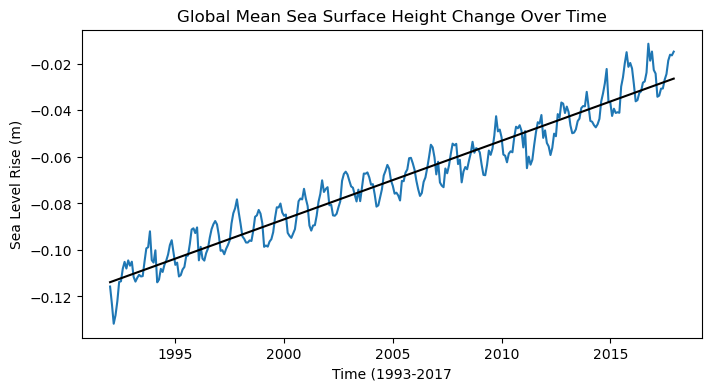

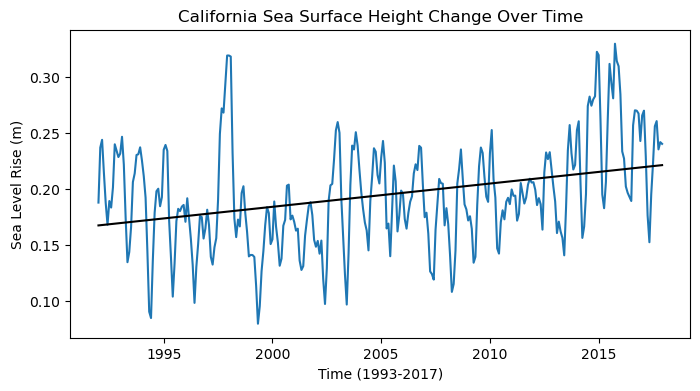

Global Trend: 3.38 mm/yr
California Trend: 2.08 mm/yr


In [9]:
# compute the trends in SLR by fitting a line to the CA and the global mean timeseries
months = np.arange(len(ts_global))
dec_yr = 1992 + months/12

# global trend
p = np.polyfit(dec_yr, ts_global[:,1], 1)

slope_global= p[0]
intercept_global= p[1]

fig = plt.figure(figsize=(8,4))
plt.plot(dec_yr, ts_global[:,1])
plt.plot(dec_yr, slope_global*dec_yr + intercept_global, color='k')
plt.title("Global Mean Sea Surface Height Change Over Time")
plt.ylabel("Sea Level Rise (m)")
plt.xlabel("Time (1993-2017")
plt.show()

# california trend
p = np.polyfit(dec_yr, ts_ca[:,1], 1)

slope_ca= p[0]
intercept_ca= p[1]

fig = plt.figure(figsize=(8,4))
plt.plot(dec_yr, ts_ca[:,1])
plt.plot(dec_yr, slope_ca*dec_yr + intercept_ca, color='k')
plt.title("California Sea Surface Height Change Over Time")
plt.ylabel("Sea Level Rise (m)")
plt.xlabel("Time (1993-2017)")
plt.show()


# print out the statistics in mm/yr for each timeseries
print("Global Trend: " + f"{slope_global*1000:.2f}" + " mm/yr")
print("California Trend: " + f"{slope_ca*1000:.2f}" + " mm/yr")

### Question:
How does the trend in sea level rise in California compare to the global mean rate?

Answer: 

The global trend in sea level rise is slightly faster than the California trend (3.38 mm/yr vs 2.08 mm/yr). However, California has a positive range for Sea Level Rise while the Global Average has a negative range.

## Part 6: Plot the Timeseries of Sea Surface Height
Finally, plot the two timeseries on the same plot along with their trend lines. Be sure to label your axes and include a legend.

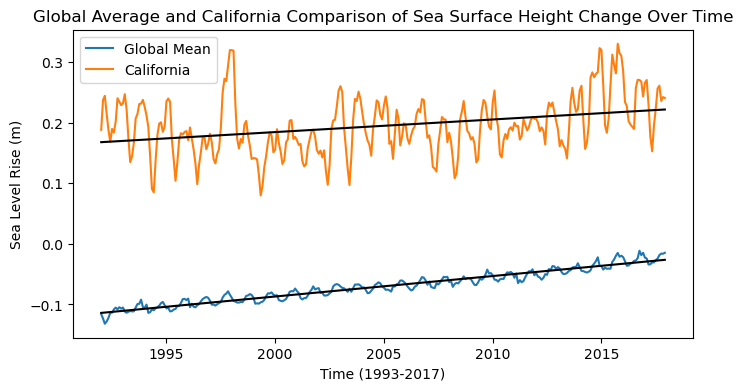

In [21]:
# create your plot here

fig = plt.figure(figsize=(8,4))

# Plot Global
plt.plot(dec_yr, ts_global[:,1], label = "Global Mean")
plt.plot(dec_yr, slope_global*dec_yr + intercept_global, color='k')

# Plot Califronia
plt.plot(dec_yr, ts_ca[:,1], label = "California")
plt.plot(dec_yr, slope_ca*dec_yr + intercept_ca, color='k')

# The Rest
plt.title("Global Average and California Comparison of Sea Surface Height Change Over Time")
plt.ylabel("Sea Level Rise (m)")
plt.xlabel("Time (1993-2017)")
plt.legend()
plt.show()

### Questions:

How do the timeseries for Calfiornia and the global mean compare? Comment on their variability. What are the two highest years of sea level in California? What oceanographic phenomenon happened during this time?

Answer:

Overall, the California time series has both a higher variability and sea level rise in general. Meanwhile, the Global Mean time series has a more stable trend of sea level rise. In California, the two highest years of sea level was in 1998 and 2015. These years coincide with El Nino events which causes warmer oceans, pressure differences, and higher precipations on coastlines.